In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter
import string
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [2]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [3]:
init_scale = 6.0

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

alpha = init_scale

is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [4]:
size = 1000
# size=10

base_csv = './IMDB Dataset.csv'
df = pd.read_csv(base_csv)

X,y = df[:size]['review'].values,df[:size]['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (750,)
shape of test data is (250,)


In [5]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

In [6]:
def tockenize(x_train,y_train,x_val,y_val):
    word_list = []
    stop_words = {'a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', "she's", 'should', "should've", 'shouldn', "shouldn't", 'so', 'some', 'such', 't', 'than', 'that', "that'll", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 've', 'very', 'was', 'wasn', "wasn't", 'we', 'were', 'weren', "weren't", 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'will', 'with', 'won', "won't", 'wouldn', "wouldn't", 'y', 'you', "you'd", "you'll", "you're", "you've", 'your', 'yours', 'yourself', 'yourselves'}
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)

    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}

    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                        if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])

    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    # return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict
    return final_list_train, encoded_train, final_list_test, encoded_test, onehot_dict

In [7]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)

In [8]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [9]:
#we have very less number of reviews with length > 500.
#So we will consider only those below it.
x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)

In [10]:
# convert to numpy
x_train_pad = np.array(x_train_pad)
y_train = np.array(y_train)
x_test_pad = np.array(x_test_pad)
y_test = np.array(y_test)

In [11]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
# batch_size = 50
batch_size = 125

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [12]:
for x, y in train_loader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([125, 500])
torch.Size([125])


In [13]:
def L2(model):
    L2_ = 0.
    for p in model.parameters():
        L2_ += torch.sum(p**2)
    return L2_

def rescale(model, alpha):
    for p in model.parameters():
        p.data = alpha * p.data

In [14]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256
wd = 1

In [15]:
class SentimentRNN(nn.Module):
    
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.0):
        super(SentimentRNN,self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.no_layers = no_layers
        self.vocab_size = vocab_size

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                            num_layers=no_layers, batch_first=True)


        # dropout layer
        self.dropout = nn.Dropout(drop_prob)

        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 

        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        # sigmoid function
        sig_out = self.sig(out)

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels

        # return last sigmoid output and hidden state
        return sig_out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [16]:
def create_model():
    global no_layers, vocab_size, hidden_dim, embedding_dim
    m = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.0).to(device)
    rescale(m, alpha)
    return m

In [17]:
# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [18]:
def model_pruner(base_model, kappa):
    """Prunes the weights of `base_model` to create a new model of the same class.
    """
    edited_model = create_model()
    state_dict = base_model.state_dict().copy()
    for key in state_dict:
        if 'weight' in key:
            state_dict[key] = F.dropout(state_dict[key], p=kappa)
    edited_model.load_state_dict(state_dict)
    return edited_model

def logit_kl_div(model1, model2, x_train, val_hidden):
    # model1.eval()
    # model2.eval()
    logits1 = model1(x_train, val_hidden)[0] 
    logits2 = model2(x_train, val_hidden)[0]
    p1 = torch.nn.functional.softmax(logits1) + 1e-8
    p2 = torch.nn.functional.softmax(logits2) + 1e-8
    kl_div = torch.sum(p1 * (torch.log(p1) - torch.log(p2)))
    return torch.mean(kl_div)

In [19]:
def smooth_entropy(model):
    return -torch.sum(torch.abs(model.fc.weight) * torch.log(torch.abs(model.fc.weight)))

In [23]:
def smooth_sparsity(model, x_train, tau):
    x_ = x_train.clone().reshape(-1, 62500)
    beta = 0.1
    return torch.mean(torch.abs(model(x_, model.init_hidden(x_.shape[0]))[0]))

In [24]:
model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.0)

#moving to gpu
model.to(device)

rescale(model, alpha)
L2_ = L2(model)

#print(model)

# loss and optimization functions
lr=0.0003

criterion = nn.BCELoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay = wd)

clip = 5
epochs = 5000
# epochs = 10
log_freq = max(1, epochs / 50)
train_loss_min = np.Inf
valid_loss_min = np.Inf
train_acc_max = 0.
valid_acc_max = 0.
# train for some number of epochs

log = {
    'log_steps': [],
    'train_losses': [],
    'test_losses': [],
    'train_accuracies': [],
    'test_accuracies': [],
    'norms': [],
    'sparsities': [],
    'weights_entropies': [],
    'greedy_circuit_complexities': [],
}

step = 0

In [25]:
for epoch in range(epochs):
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        model.train()
        inputs, labels = inputs.to(device), labels.to(device)
        if inputs.shape[0] < batch_size:
            h = model.init_hidden(inputs.shape[0])

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        model.zero_grad()
        output,h = model(inputs,h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        if step % log_freq == 0: log['train_losses'].append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc = accuracy/inputs.shape[0]
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        val_h = model.init_hidden(batch_size)
        model.eval()
        inputs, labels = next(iter(valid_loader))
        val_h = tuple([each.data for each in val_h])

        inputs, labels = inputs.to(device), labels.to(device)

        output, val_h = model(inputs, val_h)
        val_loss = criterion(output.squeeze(), labels.float())

        if step % log_freq == 0: log['test_losses'].append(val_loss.item())

        accuracy = acc(output,labels)
        val_acc = accuracy/batch_size
    if step % log_freq == 0: 
        log['test_accuracies'].append(val_acc)
        log['train_accuracies'].append(train_acc)
        print(f'step : {step} train_loss : {round(loss.item(), 3)} val_loss : {round(val_loss.item(), 3)}', end=' ')
        print(f'train_accuracy : {train_acc} val_accuracy : {val_acc}')
        log['sparsities'].append(smooth_sparsity(model, inputs, tau=0.1))
        log['weights_entropies'].append(smooth_entropy(model))
        log['norms'].append(L2(model).item())
        log['log_steps'].append(step)
        log['greedy_circuit_complexities'].append(logit_kl_div(model, model_pruner(model, 0.5), inputs, val_h))
        logit_kl_div(model, model_pruner(model, 0.5), inputs, val_h)

    step += 1

step : 0 train_loss : 0.813 val_loss : 0.854 train_accuracy : 0.52 val_accuracy : 0.464
step : 100 train_loss : 0.004 val_loss : 0.785 train_accuracy : 1.0 val_accuracy : 0.656
step : 200 train_loss : 0.001 val_loss : 1.714 train_accuracy : 1.0 val_accuracy : 0.576
step : 300 train_loss : 0.0 val_loss : 1.975 train_accuracy : 1.0 val_accuracy : 0.576
step : 400 train_loss : 0.0 val_loss : 1.372 train_accuracy : 1.0 val_accuracy : 0.672
step : 500 train_loss : 0.0 val_loss : 2.101 train_accuracy : 1.0 val_accuracy : 0.624
step : 600 train_loss : 0.0 val_loss : 1.271 train_accuracy : 1.0 val_accuracy : 0.704
step : 700 train_loss : 0.0 val_loss : 1.429 train_accuracy : 1.0 val_accuracy : 0.672
step : 800 train_loss : 0.0 val_loss : 1.636 train_accuracy : 1.0 val_accuracy : 0.736
step : 900 train_loss : 0.0 val_loss : 1.813 train_accuracy : 1.0 val_accuracy : 0.664
step : 1000 train_loss : 0.0 val_loss : 1.512 train_accuracy : 1.0 val_accuracy : 0.688
step : 1100 train_loss : 0.0 val_loss

In [39]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def dynamic_plot(log, window_size=10):
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # first, scale everything from 0 to 1 after converting to numpy
    log_steps = np.array(log['log_steps'])
    norms = np.array([n for n in log['norms']])
    sparsities = np.array([s.cpu().detach() for s in log['sparsities']])
    weights_entropies = np.array([w.cpu().detach() for w in log['weights_entropies']])
    greedy_circuit_complexities = np.array([c.cpu().detach() for c in log['greedy_circuit_complexities']])
    norms = (norms - min(norms)) / (max(norms) - min(norms) + 1e-8)
    sparsities = (sparsities - min(sparsities)) / (max(sparsities) - min(sparsities) + 1e-8)
    weights_entropies = (weights_entropies - min(weights_entropies)) / (max(weights_entropies) - min(weights_entropies) + 1e-8)
    greedy_circuit_complexities = (greedy_circuit_complexities - min(greedy_circuit_complexities)) / (max(greedy_circuit_complexities) - min(greedy_circuit_complexities) + 1e-8)

    # moving average for each of them
    # fill
    # Calculate moving averages
    norms = moving_average(norms, window_size)
    sparsities = moving_average(sparsities, window_size)
    weights_entropies = moving_average(weights_entropies, window_size)
    greedy_circuit_complexities = moving_average(greedy_circuit_complexities, window_size)

    # Adjust log_steps to match the length of moving averages
    log_steps_ma = log_steps[window_size - 1:]

    fig.add_trace(go.Scatter(opacity=1, line_smoothing=0.8, x=log_steps, y=log['train_accuracies'], mode='lines', name='train accuracy', line=dict(width=4, color='red')),secondary_y=False,)
    fig.add_trace(go.Scatter(opacity=1, line_smoothing=0.8, x=log_steps, y=log['test_accuracies'], mode='lines', name='test accuracy', line=dict(width=4, color='green')),secondary_y=False,)
    fig.add_trace(go.Scatter(opacity=0.8, line_smoothing=0.8, x=log_steps, y=norms, mode='lines', name='weight norm (L2)', line=dict(width=2, color='purple')),secondary_y=True,)
    fig.add_trace(go.Scatter(opacity=0.8, line_smoothing=0.8, x=log_steps, y=sparsities, mode='lines', name='activation sparsity', line=dict(width=2, color='blue')),secondary_y=True,)
    fig.add_trace(go.Scatter(opacity=0.8, line_smoothing=0.8, x=log_steps, y=weights_entropies, mode='lines', name='weight entropy', line=dict(width=2, color='orange')),secondary_y=True,)
    fig.add_trace(go.Scatter(opacity=0.8, line_smoothing=0.8, x=log_steps, y=greedy_circuit_complexities, mode='lines', name='local circuit complexity', line=dict(width=2, color='black')),secondary_y=True,)

    fig.update_xaxes(title_text="Optimization Steps", type='log')
    fig.update_yaxes(title_text="<b>Normalized Measure</b>", secondary_y=False)

    fig.update_layout({'plot_bgcolor': 'rgba(255, 255, 255, 1)',})

    fig.update_layout(
        xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray'),
        yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray'),
    )

    fig.update_layout(autosize=False, width=1000, height=600,)

    fig.update_traces(line=dict(width=4))

    # font size
    fig.update_layout(legend = dict(font = dict(size = 20, color = "black")),
                  legend_title = dict(font = dict(size = 20, color = "blue")))

    return fig

In [40]:
fig = dynamic_plot(log)
path = './plots/decreasing_norm_imdb.pdf'
fig.write_image(path)

In [36]:
smooth_sparsity(model, inputs, tau=0.1)

tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
# train(1000, 1.0, 0.0)

Text(1.2, 0.95, '$\\alpha=6$')

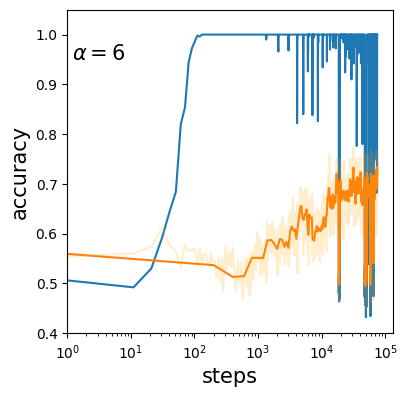

In [ ]:
plt.figure(figsize=(4.2,4.2))

plt.subplot(1,1,1)

train_losses = np.loadtxt("./results_grok/trainacc_size_1000_scale_6.0000_wd_1.0000")
test_losses = np.loadtxt("./results_grok/testacc_size_1000_scale_6.0000_wd_1.0000")

plt.plot((np.arange(len(train_losses))+1)[::10], np.mean(np.array(train_losses).reshape(-1,10), axis=1), alpha=1.0)
plt.plot((np.arange(len(test_losses))+1)[::200], np.mean(np.array(test_losses).reshape(-1,200), axis=1), alpha=1.0)
plt.plot((np.arange(len(test_losses))+1)[::10], np.mean(np.array(test_losses).reshape(-1,10), axis=1), alpha=0.2, color="orange")
#plt.plot(test)
plt.xscale('log')
plt.xlim(1,)
plt.ylim(0.4,1.05)
#plt.plot([0,1e5],[0.5,0.5], ls="--")
plt.xlabel('steps', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.text(1.2,0.95,r"$\alpha=6$", fontsize=15)